## Assignment 2 - Part 1 - CIVENG 263H Fall 2023
### Erin jones
### Deadline: 9/24/2023

In [28]:
import numpy as np
import pandas as pd
import random as rd
import sys, os
import scipy.io as sio
import pickle
rd.seed(50)

# import additional packages

import matplotlib.pyplot as plt #for plots
import matplotlib.cm as cm  #for color maps
import matplotlib as mpl #for color matrices
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns # can also be used for plots

from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal

from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

In [29]:
# reads the data and loads data for subject 25
filename = 'realitymining_pick'
infile = open(filename,'rb')
s = pickle.load(infile) 
infile.close()

def load_subject_data(subject_id, loaded_pickle):

    subject_data = loaded_pickle['data_mat'][0,(subject_id - 1)].transpose()
    
    # parse data to corresponding time and days
    hours=np.size(subject_data,1)
    days=np.size(subject_data,0)
    num_labels=5
    subject_array=np.zeros([days,hours*num_labels])
    name_column=[]

    for j in range(1,np.size(subject_array,1)+1):
        J1=hours*(num_labels-1)+1 #97=24*(5-1)+1
        if j >= J1:      
            name_column.append(str(j-J1)+'_off')
        else:
            J2=hours*(num_labels-2)+1
            if j>=J2:
                name_column.append(str(j-J2)+'_nsg')
            else:
                J3=hours*(num_labels-3)+1
                if j >= J3:
                    name_column.append(str(j-J3)+'_els')
                else:
                    J4=hours*(num_labels-4)+1
                    if j >= J4:
                        name_column.append(str(j-J4)+'_wrk')
                    else:
                        name_column.append(str(j-1)+'_hom')

    for i in range(1,days+1):
        for j in range(1,hours+1):
            place=subject_data[i-1][j-1]
            if np.isnan(place):
                Ji=hours*(num_labels-1)+1 #97=24*(5-1)+1
                Jf=hours*num_labels #120
                J=Ji+j-1
                subject_array[i-1][J-1]=1
            else:
                if place==0:
                    Ji=hours*(num_labels-2)+1 #73
                    Jf=hours*(num_labels-1)   #96
                    J=Ji+j-1
                    subject_array[i-1][J-1]=1
                else:
                    Ji=int(hours*(place-1)+1) # (1-24) for house and (25-48) for work 
                    Jf=int(hours*place)       # and (49-72) for elsewehere
                    J=int(Ji+j-1)
                    subject_array[i-1][J-1]=1

    return subject_array, hours, days

In [30]:
Mbw25, hours, days = load_subject_data(25, s)

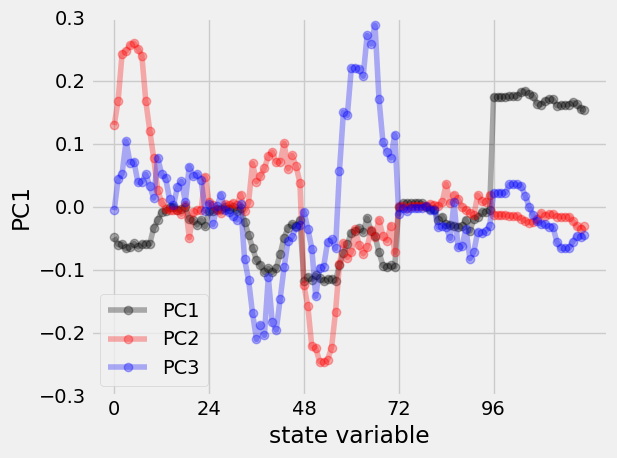

The principal components of this dataset are:
         PC 1      PC 2      PC 3      PC 4      PC 5      PC 6      PC 7  \
0   -0.049030  0.129238 -0.005709  0.105796  0.050763  0.049884 -0.122795   
1   -0.060461  0.168186  0.043461  0.072531  0.098697 -0.046446 -0.120924   
2   -0.059949  0.242737  0.051737  0.094076  0.029519 -0.078249 -0.055873   
3   -0.066492  0.246476  0.103658  0.077253 -0.022807 -0.079747 -0.021423   
4   -0.064836  0.255817  0.069745  0.093419 -0.018141 -0.096496  0.023964   
..        ...       ...       ...       ...       ...       ...       ...   
115  0.161582 -0.015955 -0.066333  0.107855 -0.029723 -0.142212 -0.029948   
116  0.165374 -0.022317 -0.056542  0.110566 -0.041170 -0.134022 -0.040836   
117  0.162645 -0.030791 -0.046598  0.131420 -0.046492 -0.110156 -0.043513   
118  0.154894 -0.035659 -0.048302  0.138650 -0.043386 -0.113321 -0.049851   
119  0.153927 -0.031637 -0.045855  0.147634 -0.041013 -0.111558 -0.059162   

         PC 8      PC 9     P

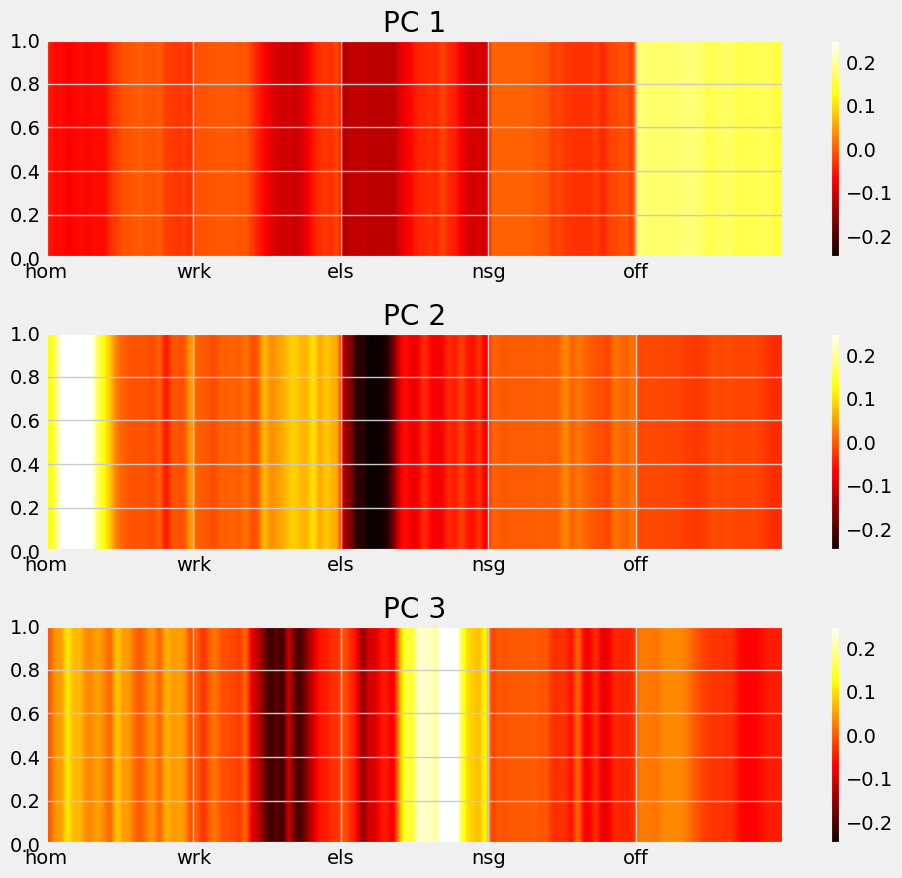

In [55]:
# considering all columns as number_c
number_c=120
pca25 = PCA(n_components=number_c)  ##Estimates the components
pca25.fit(Mbw25)
Mbw_pca25=pca25.fit_transform(Mbw25)
Mbw_recons25 = pca25.inverse_transform(Mbw25)

# shows the plot of the first three PCs
x = np.arange(hours*num_labels)
plt.plot(x,pca25.components_[0,:], 'o-', color='black', alpha=0.3, label= "PC1")
plt.plot(x,pca25.components_[1,:], 'o-', color='red', alpha=0.3, label= "PC2")
plt.plot(x,pca25.components_[2,:], 'o-', color='blue', alpha=0.3, label= "PC3")
plt.ylim([-0.3, 0.3])
plt.xticks(np.arange(0, 120, step=24))
plt.xlabel("state variable")
plt.ylabel("PC1")
plt.tight_layout()
plt.legend()
plt.savefig("./11pc1.pdf")
plt.show()


# reproduces the figure from the paper

PC_dictionnary = {} #this step creates a Data frames with the PCs
Principal_components_names = ['PC ' + str(i) for i in range(1,len(name_column)+1)]
for idx in range(len(Principal_components_names)):
    PC_dictionnary[Principal_components_names[idx]] = pca25.components_[idx]

PC_data = pd.DataFrame(data = PC_dictionnary) 
print("The principal components of this dataset are:")
print(PC_data)

PC_np = PC_data.values
name_state = ['hom','wrk','els','nsg','off']
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(10,9))

im=ax1.imshow(np.transpose(PC_np[:,0:1]),vmin=-0.25,vmax=0.25,extent=[0,120,0,1], aspect='auto',cmap=cm.hot,interpolation='spline16')
ax1.set_title('PC 1')
fig.colorbar(im, ax=ax1)
ax1.set_xticks(np.arange(0,120,24))
ax1.set_xticklabels(name_state)

im2=ax2.imshow(np.transpose(PC_np[:,1:2]),vmin=-0.25,vmax=0.25,extent=[0,120,0,1], aspect='auto',cmap=cm.hot,interpolation='spline16')
ax2.set_title('PC 2')
fig.colorbar(im2, ax=ax2)
ax2.set_xticks(np.arange(0,120,24))
ax2.set_xticklabels(name_state)

im3=ax3.imshow(np.transpose(PC_np[:,2:3]),vmin=-0.25,vmax=0.25,extent=[0,120,0,1], aspect='auto',cmap=cm.hot,interpolation='spline16')
ax3.set_title('PC 3')
fig.colorbar(im3, ax=ax3)
ax3.set_xticks(np.arange(0,120,24))
ax3.set_xticklabels(name_state)

plt.tight_layout()
# plt.savefig("./11pc2.pdf")

## Question 1

Based on the plot above, PC1 does a great job at representing the eigenbehavior where the user has their device turned off for essentially the entire day. PC2 does a fantastic job assessing when someone is home or elsewhere in the first half of the day (strong positive/negative projections). PC3 does an excellent job describing a behavior where the subject is elsewhere for the latter 2/3 of the day (possibly running errands?) and describes the occassional behavior where there is a stop at work in the afternoon/evening. There are also hints of the individual active at home for bits and pieces of the day, but nothing when compared to the magnitude of the PC3 value for the elsewhere category. See the description of the activity for each day below in the markdown below the given plot.

In [32]:
Mbw_pca25.shape

(162, 120)

The 3 projections for Day 10 are: 
[-1.1349868   2.26258669  0.73163401]


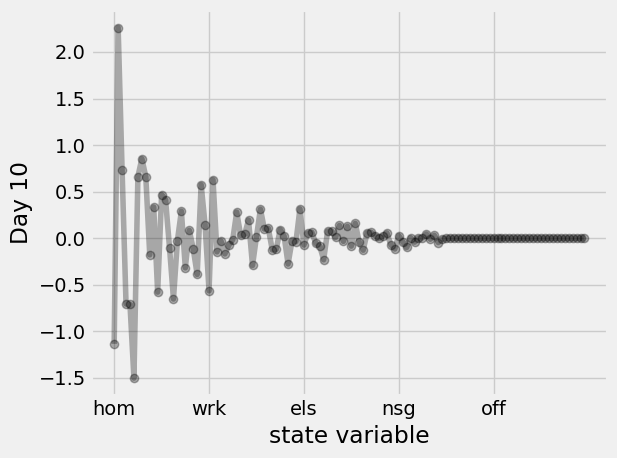

In [62]:
# Day 10
x = np.arange(hours*num_labels)
plt.plot(x,Mbw_pca25[9,:], 'o-', color='black', alpha=0.3)
# plt.xticks(np.arange(0, 120, step=24))
plt.xticks(np.arange(0, 120, step=24), labels=name_state)
plt.xlabel("state variable")
plt.ylabel("Day 10")
plt.tight_layout()

# prints the tenth day and 3 projections (Principal components for specific day)
print("The 3 projections for Day 10 are: ")
print(Mbw_pca25[9,:3])

The pattern for day 10 appears to represent very high likelihood that the individual is home during the first part of their day and then less so as the day goes on. There also appears to be a good amount of activity during the middle of the day related to their being at work. Day 10 has little activity elsewhere (maybe a weekday) and it definitely seems that their device was not likely to be found off on that day.

The 3 projections for Day 15 are: 
[-1.22729175 -1.33670925 -1.45511471]


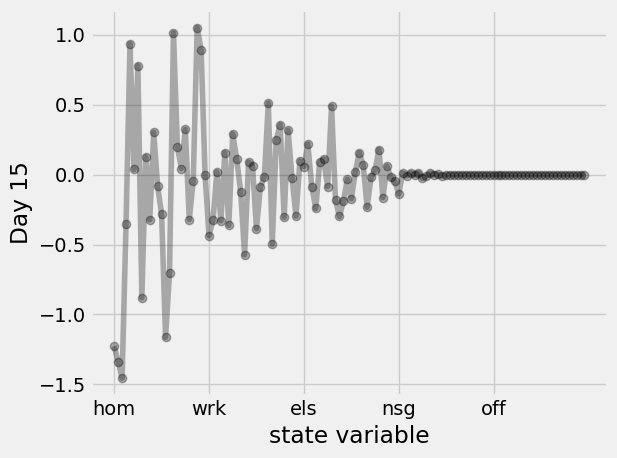

In [58]:
# Day 15
x = np.arange(hours*num_labels)
plt.plot(x,Mbw_pca25[14,:], 'o-', color='black', alpha=0.3)
plt.xticks(np.arange(0, 120, step=24), labels=name_state)
plt.xlabel("state variable")
plt.ylabel("Day 15")
plt.tight_layout()

# prints the first day and 3 projections (Principal components for specific day)
print("The 3 projections for Day 15 are: ")
print(Mbw_pca25[14,:3])

On day 15, the subject spent a good amount of time going to and from home, with an equal amount of time appearing to be spent either elsewhere or at work. This is a day not spent straight between home and work, but rather maybe a day that was also spent elsewhere. It seems their device was on the majority of the time.

The 3 projections for Day 20 are: 
[ 1.70321062 -0.04325883  0.97991906]


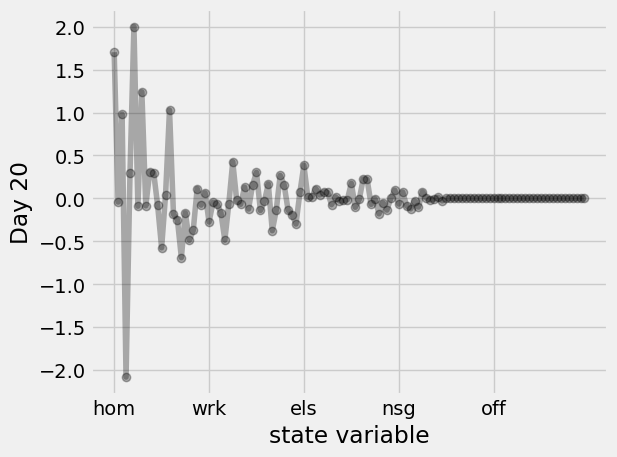

In [59]:
# Day 20
x = np.arange(hours*num_labels)
plt.plot(x,Mbw_pca25[19,:], 'o-', color='black', alpha=0.3)
plt.xticks(np.arange(0, 120, step=24), labels=name_state)
plt.xlabel("state variable")
plt.ylabel("Day 20")
plt.tight_layout()

# prints the first day and 3 projections (Principal components for specific day)
print("The 3 projections for Day 20 are: ")
print(Mbw_pca25[19,:3])

Day 20 is very similar in terms of behavior patterns to Day 10, however more time is spent at home than on that day. There also seems to be less activity elsewhere than on other days. Again, this subject appears to like to have their phone on a whole lot!

## Question 2



In [36]:
# Reconstruction of Sample Days with First 3 Eigenvectors

pca25_3 = PCA(3)

Mbw25_pca3= pca25_3.fit_transform(Mbw25)
MBW_recons25_3 = pca25_3.inverse_transform(pca25_3.fit_transform(Mbw25))

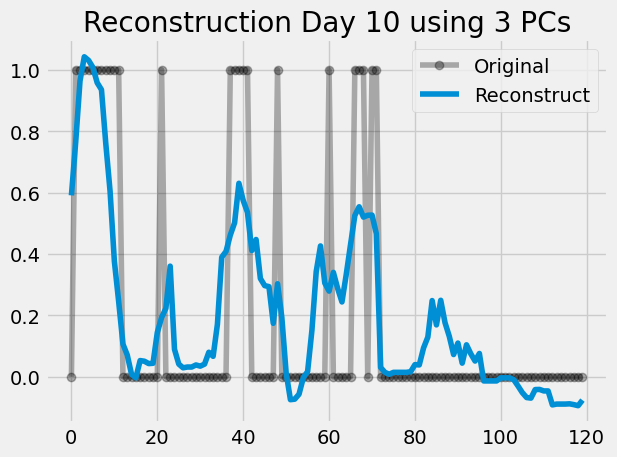

In [37]:
# shows the reconstruction of Day 10

x = np.arange(hours*num_labels)
plt.plot(x,Mbw25[9,:], 'o-', color='black', alpha=0.3,label="Original")
plt.plot(x,MBW_recons25_3[9,:],label="Reconstruct")

plt.title('Reconstruction Day 10 using 3 PCs')
plt.tight_layout()
plt.legend()

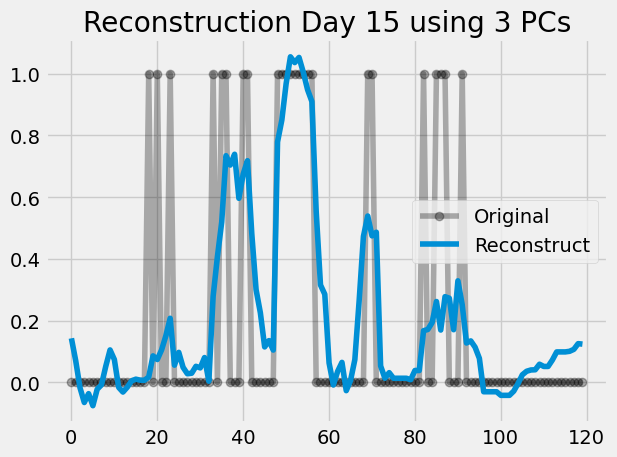

In [38]:
# shows the reconstruction of Day 15

x = np.arange(hours*num_labels)
plt.plot(x,Mbw25[14,:], 'o-', color='black', alpha=0.3,label="Original")
plt.plot(x,MBW_recons25_3[14,:],label="Reconstruct")

plt.title('Reconstruction Day 15 using 3 PCs')
plt.tight_layout()
plt.legend()

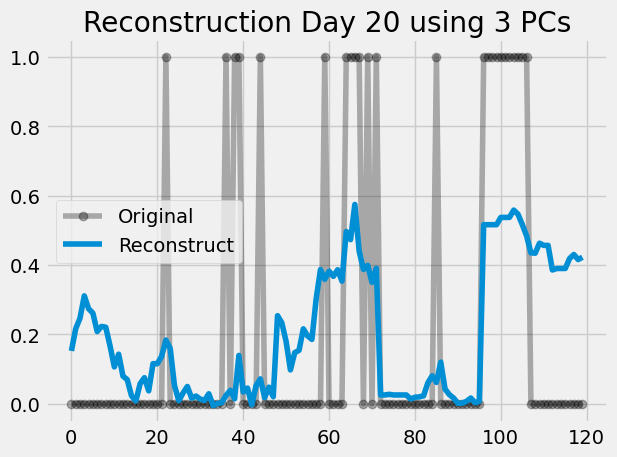

In [39]:
# shows the reconstruction of Day 20

x = np.arange(hours*num_labels)
plt.plot(x,Mbw25[19,:], 'o-', color='black', alpha=0.3,label="Original")
plt.plot(x,MBW_recons25_3[19,:],label="Reconstruct")

plt.title('Reconstruction Day 20 using 3 PCs')
plt.tight_layout()
plt.legend()

In [40]:
# Question 3

## Variance attributed to each PC

variance_pc1 = pca25.explained_variance_ratio_[0:119][0]
variance_pc2 = pca25.explained_variance_ratio_[0:119][1]
variance_pc3 = pca25.explained_variance_ratio_[0:119][2]

print(f"The percentage of variance explained by PC1 is {((variance_pc1)*100):.2f}%")
print(f"The percentage of variance explained by PC2 is {((variance_pc2)*100):.2f}%")
print(f"The percentage of variance explained by PC3 is {((variance_pc3)*100):.2f}%")
print(f"Therefore, the total variance explained by the first three components is {(((variance_pc1 + variance_pc2 + variance_pc3))*100):.2f}%")

The percentage of variance explained by PC1 is 24.99%
The percentage of variance explained by PC2 is 13.66%
The percentage of variance explained by PC3 is 6.81%
Therefore, the total variance explained by the first three components is 45.46%


In [41]:
# DAY 10
for i in range(1,120):
    pca25_n = PCA(i)
    MBW_recons25_n = pca25_n.inverse_transform(pca25_n.fit_transform(Mbw25))
    acc = 1.00-np.sum(np.square(Mbw25[9,:]-MBW_recons25_n[9,:]))/np.sum(np.square(Mbw25[9,:]))
    if acc>=0.80:
        print(f"The first {i} PCs achieve a reconstruction accuracy of {acc} for day 10")
        break

# DAY 15
for i in range(1,120):
    pca25_n = PCA(i)
    MBW_recons25_n = pca25_n.inverse_transform(pca25_n.fit_transform(Mbw25))
    acc = 1.00-np.sum(np.square(Mbw25[14,:]-MBW_recons25_n[14,:]))/np.sum(np.square(Mbw25[14,:]))
    if acc>=0.80:
        print(f"The first {i} PCs achieve a reconstruction accuracy of {acc} for day 15")
        break

# DAY 20
for i in range(1,120):
    pca25_n = PCA(i)
    MBW_recons25_n = pca25_n.inverse_transform(pca25_n.fit_transform(Mbw25))
    acc = 1.00-np.sum(np.square(Mbw25[19,:]-MBW_recons25_n[19,:]))/np.sum(np.square(Mbw25[19,:]))
    if acc>=0.80:
        print(f"The first {i} PCs achieve a reconstruction accuracy of {acc} for day 20")
        break

The first 7 PCs achieve a reconstruction accuracy of 0.8035822443195857 for day 10
The first 22 PCs achieve a reconstruction accuracy of 0.8454542417958437 for day 15
The first 8 PCs achieve a reconstruction accuracy of 0.8259303516093788 for day 20


In [42]:
## Q4 

accuracy_dict = {}

for i in range(0,((MBW_recons25_3.shape)[0])):
    pca25_3 = PCA(3)
    MBW_recons25_3 = pca25_3.inverse_transform(pca25_3.fit_transform(Mbw25))
    acc = 1.00-np.sum(np.square(Mbw25[i,:]-MBW_recons25_3[i,:]))/np.sum(np.square(Mbw25[i,:]))
    # Correct for the indexing starting at 0
    day_in_laymens = i + 1
    accuracy_dict[f"Day {day_in_laymens}"] = acc

min_value = min(accuracy_dict.values())
min_key = [key for key, value in accuracy_dict.items() if value == min_value][0]

print(f"The day with the minimum accuracy score when using 3 PCs to reconstruct is: {min_key}. Because the accuracy is the lowest of all the accuracy scores for each day when represented by 3 PCs, \nit is the worst represented by this number of components.")

The day with the minimum accuracy score when using 3 PCs to reconstruct is: Day 101. Because the accuracy is the lowest of all the accuracy scores for each day when represented by 3 PCs, 
it is the worst represented by this number of components.


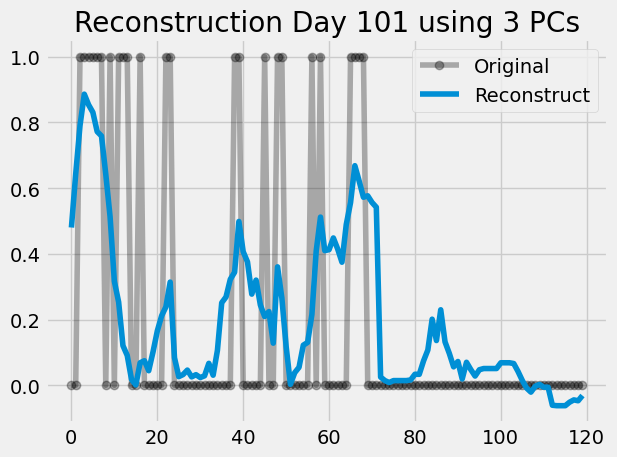

In [43]:
# Let's take a look at that reconstruction for the purposes of intuition

x = np.arange(hours*num_labels)
plt.plot(x,Mbw25[101,:], 'o-', color='black', alpha=0.3,label="Original")
plt.plot(x,MBW_recons25_3[101,:],label="Reconstruct")

plt.title('Reconstruction Day 101 using 3 PCs')
plt.tight_layout()
plt.legend()

## Part 2 - K Means

In [44]:
Mbw4 = (load_subject_data(4, s))[0]
Mbw16 = (load_subject_data(16, s))[0]

In [45]:
# 25 - ideal number of clusters is 3

def create_projected_data(n_components, loaded_subject_array):
    pca_n = PCA(n_components)
    projected_data = pca_n.fit_transform(loaded_subject_array)
    return projected_data, pca_n

def elbow_test(projected_data):
    Sum_of_squared_distances = []
    K = range(1,10)
    for k in K:
        km = KMeans(n_clusters=k, n_init=10)
        km = km.fit(projected_data)
        Sum_of_squared_distances.append(km.inertia_)


    plt.figure(figsize = (10,6))
    ax = plt.gca()
    plt.plot(K, Sum_of_squared_distances, linewidth = 2)
    plt.plot(K, Sum_of_squared_distances, '.', c='r',markersize = 6)
    plt.plot(K,[Sum_of_squared_distances[-1] for i in range(len(Sum_of_squared_distances))],'--',
            linewidth = 1.5, c = 'black')

    plt.xlabel('Number of clusters', fontsize = 12)
    plt.ylabel('Sum of squared distances', fontsize = 12)
    plt.title('Variation of the sum of squared distances in function of the number of clusters', fontsize = 15, y = 1.05)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.grid(True)
    return plt.show()


The elbow test for subject 4 is:


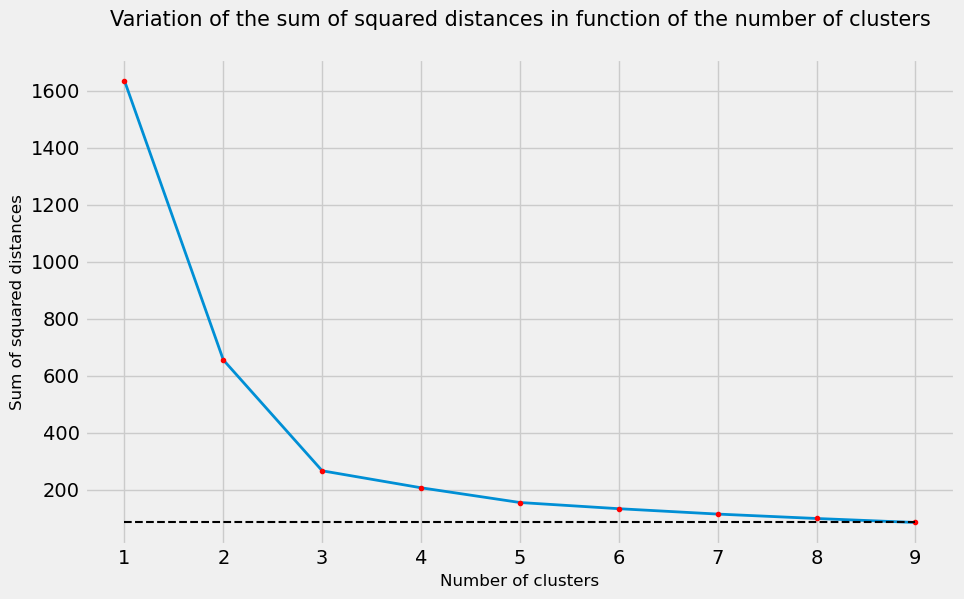

The elbow test for subject 16 is:


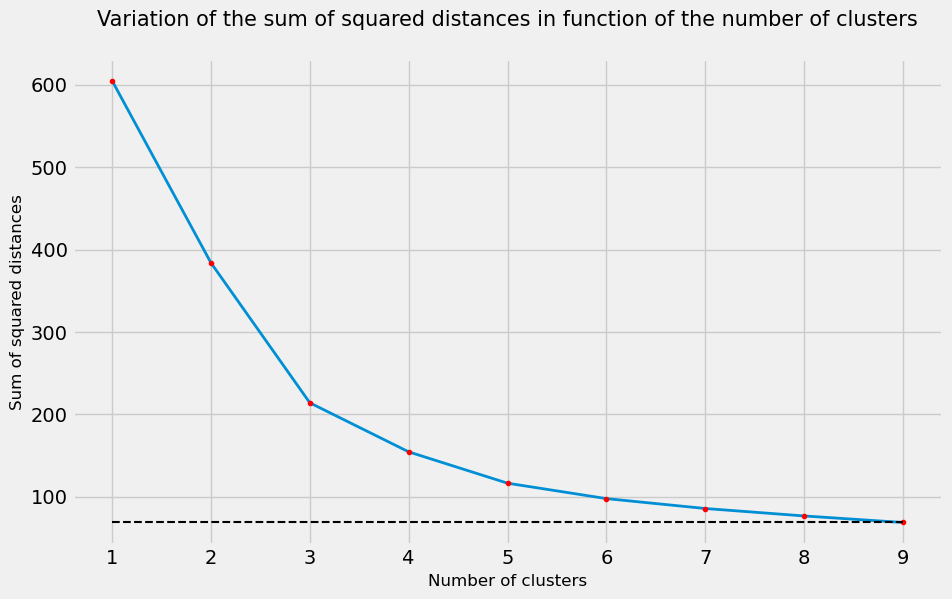

The elbow test for subject 25 is:


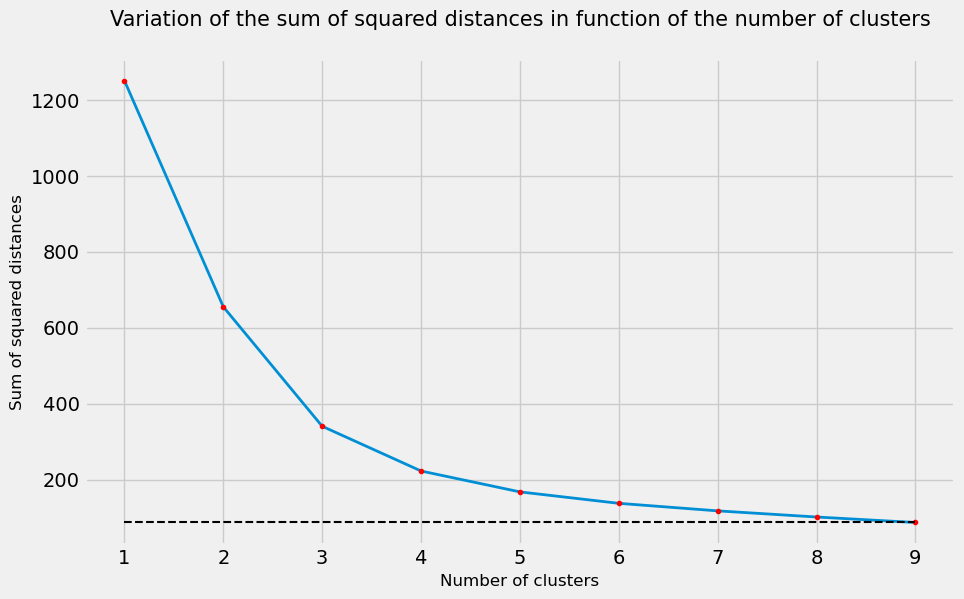

In [46]:
# Run the elbow test on all subjects -- even as you add more components, it seems to hover around about 3 clusters

# Subject 4
projected_data_4, pca4_3 = create_projected_data(3, Mbw4)
print("The elbow test for subject 4 is:")
elbow_test(projected_data_4)


# Subject 16
projected_data_16, pca16_3 = create_projected_data(3, Mbw16)
print("The elbow test for subject 16 is:")
elbow_test(projected_data_16)


# Subject 25
projected_data_25, pca25_3 = create_projected_data(3, Mbw25)
print("The elbow test for subject 25 is:")
elbow_test(projected_data_25)

Based on the above information - 3 clusters seems to be the ideal number of clusters

The clusters produced for subject 4's PCs is as follows: 


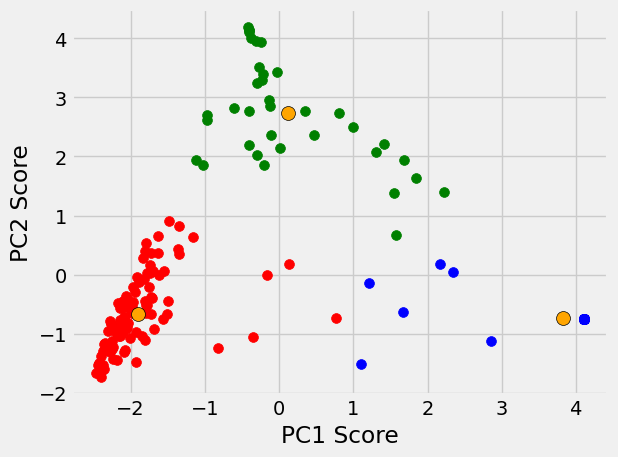

The clusters produced for subject 16's PCs is as follows: 


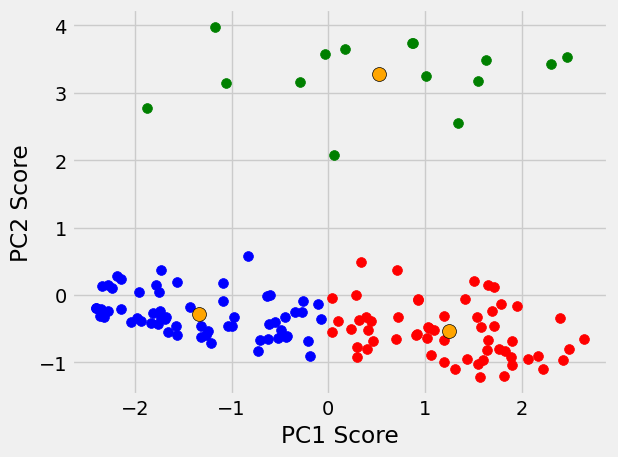

The clusters produced for subject 25's PCs is as follows: 


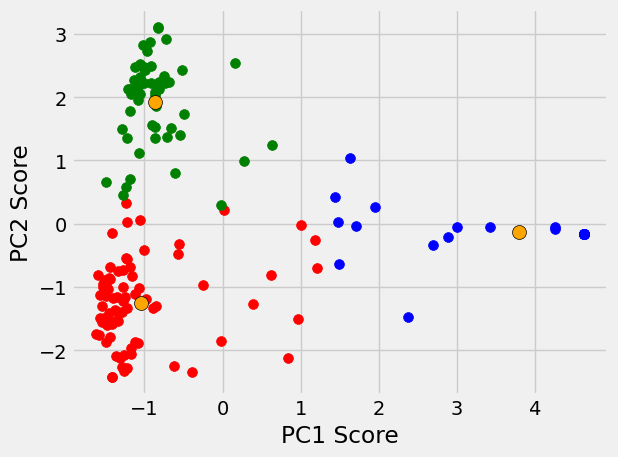

In [68]:
def run_plot_kmeans(n_clusters, projected_data, pca_n):

    kmeans = KMeans(n_clusters = n_clusters,random_state=1, n_init = 10)
    membership = kmeans.fit_predict(projected_data) #Important this can be done projecting with any number of PCs 
    Score = kmeans.score(projected_data)
    centers = kmeans.cluster_centers_
    centers_initial_base = pca_n.inverse_transform(centers)

    inertia = kmeans.inertia_
    y_km = membership

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']
    f = 0
    for i in range(0, n_clusters):
        plt.scatter(projected_data[y_km ==i,0], projected_data[y_km == i,1], s=50, c=colors[f])
        f+=1 
    
    plt.scatter(kmeans.cluster_centers_[:, 0],kmeans.cluster_centers_[:, 1], c=colors[f],s=100, label='Centroids', edgecolors='black')
    
    plt.xlabel("PC1 Score")
    plt.ylabel("PC2 Score")
    plt.tight_layout()

    plt.show()

    return membership, inertia, kmeans.cluster_centers_

# Subject 4
print("The clusters produced for subject 4's PCs is as follows: ")
s4_km_membership, s4_inertia, s4_centroids = run_plot_kmeans(3, projected_data_4, pca4_3)


# Subject 16
print("The clusters produced for subject 16's PCs is as follows: ")
s16_km_membership, s16_inertia, s16_centroids = run_plot_kmeans(3, projected_data_16, pca16_3)


# Subject 25
print("The clusters produced for subject 25's PCs is as follows: ")
s25_km_membership, s25_inertia, s25_centroids = run_plot_kmeans(3, projected_data_25, pca25_3)

It seems as though subject 4's behavior aligns more with the behavior of subject 25 just based on a visual inspection of the chart. The red and green clusters seem to be clustered densely on the lefthand side of the chart, whereas the blue cluster is sparsely populated and sits on the lefthand side of the plot. Additionally, based on the analysis of membership below, the distribution of PCs in each cluster for subject 4 is far more similar to that of subject 25 than that of subject 16.

In [84]:
euclidean_distances_s4_s16 = [euclidean(p1, p2) for p1, p2 in zip(s4_centroids, s16_centroids)]
euclidean_distances_s4_s25 = [euclidean(p1, p2) for p1, p2 in zip(s4_centroids, s25_centroids)]

In [89]:
print("The individual euclidean distances for the centroids of clusters in s4 vs those in s16 are: ")
print(euclidean_distances_s4_s16)
print(np.mean(euclidean_distances_s4_s16))
print("\n")
print("The individual euclidean distances for the centroids of clusters in s4 vs those in s25 are: ")
print(euclidean_distances_s4_s25)
print(np.mean(euclidean_distances_s4_s25))

The individual euclidean distances for the centroids of clusters in s4 vs those in s16 are: 
[3.1443840578238293, 5.17036901728634, 0.7282249895075766]
3.014326021539249


The individual euclidean distances for the centroids of clusters in s4 vs those in s25 are: 
[1.0378568141296352, 0.6022257544088024, 1.2727548713251997]
0.9709458132878792


Given the graphs and the quantitative analysis of the distances between centroids of subject 4's clusters vs both subject 16 and 25's clusters, it is safe to say that subject 4 is far more similar in behavior patterns to subject 25. We can see the distribution of data amongst clusters is also more similar between s4 and s25 based on the below code.

In [52]:
def membership_stats(km_membership, n_clusters, subject_number):
    print(f"The k-means membership statistics for subject {subject_number} are: ")
    N = len(km_membership)
    percentage_list = []
    nb_of_people_list = []
    for i in range(n_clusters):
        percentage_list.append(round(100*(km_membership== i).sum()/N,2))
        nb_of_people_list.append((km_membership == i).sum())
        print("The cluster " + str(i + 1) + " includes {:.2f}%".format(percentage_list[-1]),"of the days.")
    print("\n")

# Subject 4
membership_stats(s4_km_membership, 3, 4)
print(f"The inertia for clustering on subject 4 is {s4_inertia}\n")

# Subject 16
membership_stats(s16_km_membership, 3, 16)
print(f"The inertia for clustering on subject 16 is {s16_inertia}\n")

# Subject 25
membership_stats(s25_km_membership, 3, 25)
print(f"The inertia for clustering on subject 25 is {s25_inertia}\n")


The k-means membership statistics for subject 4 are: 
The cluster 1 includes 53.89% of the days.
The cluster 2 includes 26.11% of the days.
The cluster 3 includes 20.00% of the days.


The inertia for clustering on subject 4 is 267.1676058659599

The k-means membership statistics for subject 16 are: 
The cluster 1 includes 43.70% of the days.
The cluster 2 includes 45.19% of the days.
The cluster 3 includes 11.11% of the days.


The inertia for clustering on subject 16 is 214.18011019768733

The k-means membership statistics for subject 25 are: 
The cluster 1 includes 47.53% of the days.
The cluster 2 includes 20.37% of the days.
The cluster 3 includes 32.10% of the days.


The inertia for clustering on subject 25 is 340.6013714184267

